# Hourly Energy Consumption

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os
import pandas as pd 
import seaborn as sns
plt.style.use('seaborn-v0_8-white')
color_pal = sns.color_palette()

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Importing and EDA all Data

In [2]:
# Data is saved in parquet format so schema is preserved.
df = pd.read_parquet('/Users/macbookpro/Desktop/LinkedIn Work/LinkedIn Posts/Predective Modeling Projects/Hourly Energy Consumption/est_hourly.paruqet')

In [3]:
df.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


In [4]:
df.tail()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,NaN,44284.0,8401.0,NaN
2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,NaN,43751.0,8373.0,NaN
2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,NaN,42402.0,8238.0,NaN
2018-01-01 23:00:00,20415.0,13336.0,2614.0,4224.0,17814.0,1820.0,2880.0,8676.0,NaN,40164.0,7958.0,NaN
2018-01-02 00:00:00,19993.0,12816.0,2552.0,4100.0,17428.0,1721.0,2846.0,8393.0,NaN,38608.0,7691.0,NaN


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


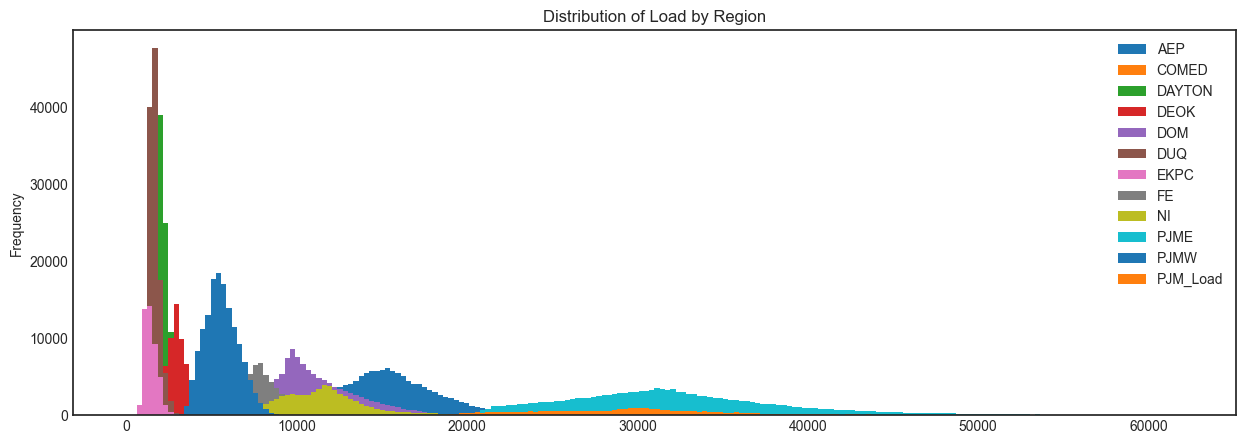

In [6]:
_ = df.plot.hist(figsize=(15, 5), bins=200, title='Distribution of Load by Region')

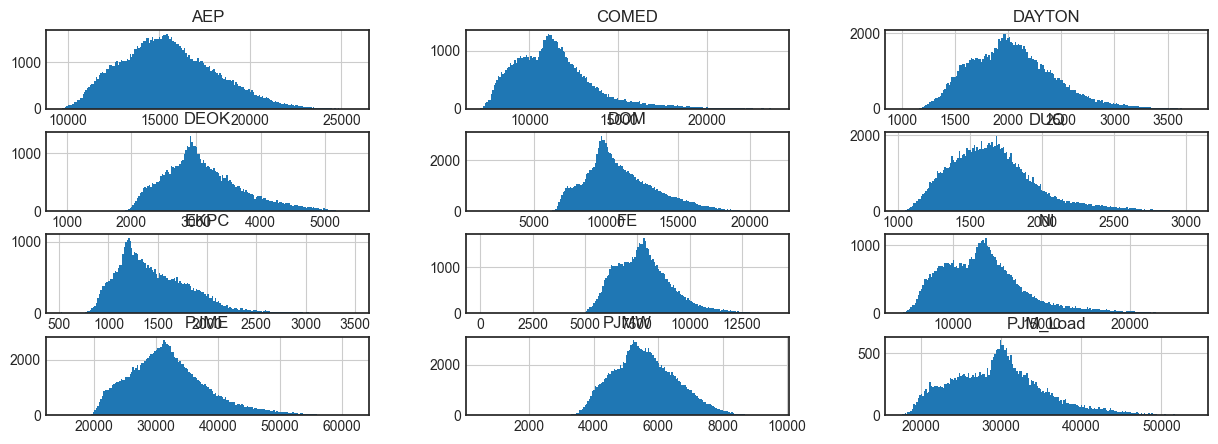

In [7]:
# Distribution of Load by Region
fig, ax = plt.subplots(figsize=(15, 5))
df.hist(ax=ax, bins=200)
ax.set_title('Distribution of Load by Region')
plt.show()

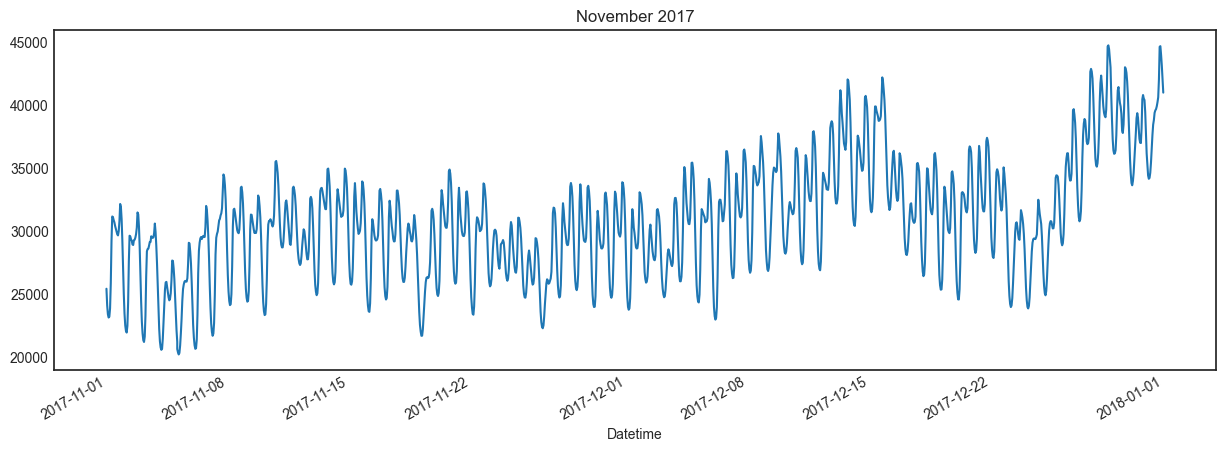

In [8]:
_ = df['PJME'].loc[(df['PJME'].index >= '2017-11-01') &
               (df['PJME'].index < '2018-01-01')] \
    .plot(figsize=(15, 5), title = 'November 2017')

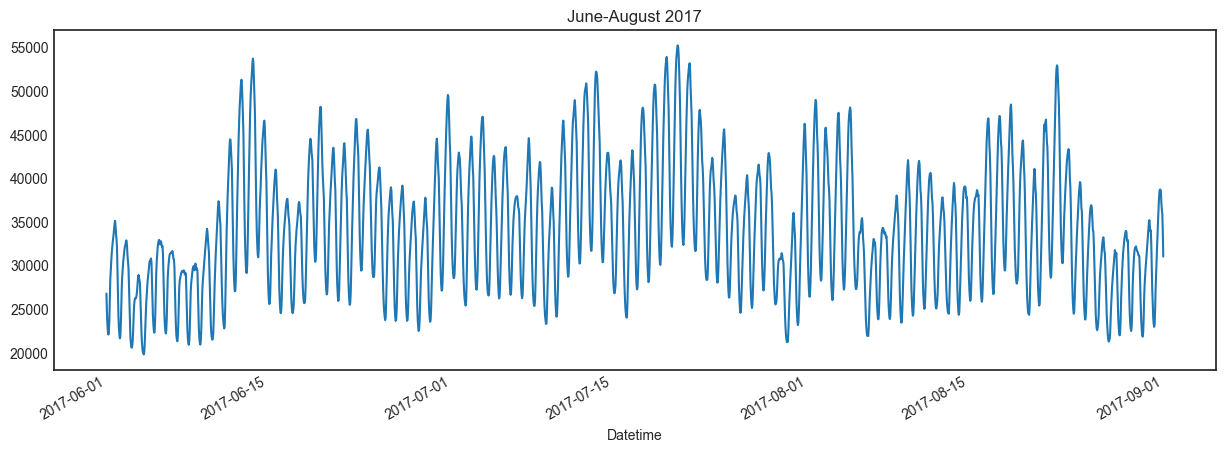

In [9]:
_ = df['PJME'].loc[(df['PJME'].index >= '2017-06-01') &
               (df['PJME'].index < '2017-09-01')] \
    .plot(figsize=(15, 5), title = 'June-August 2017')

# Create Time Series Features

In [10]:
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name
df['woy'] = df.index.weekofyear
df['dom'] = df.index.day # Day of Month
df['date'] = df.index.date 

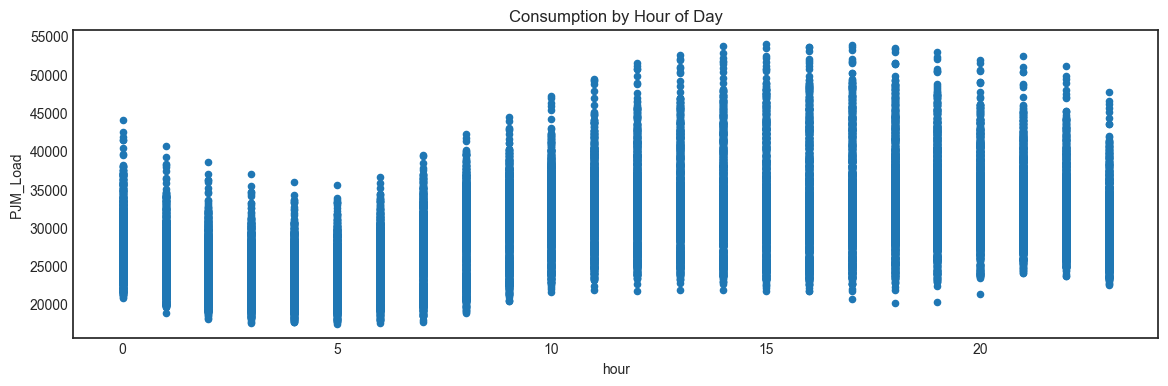

In [11]:
_ = df[['PJM_Load','hour']].plot(x='hour',
                                     y='PJM_Load',
                                     kind='scatter',
                                     figsize=(14,4),
                                     title='Consumption by Hour of Day')

# Trends change depending on time of year

(0.0, 65000.0)

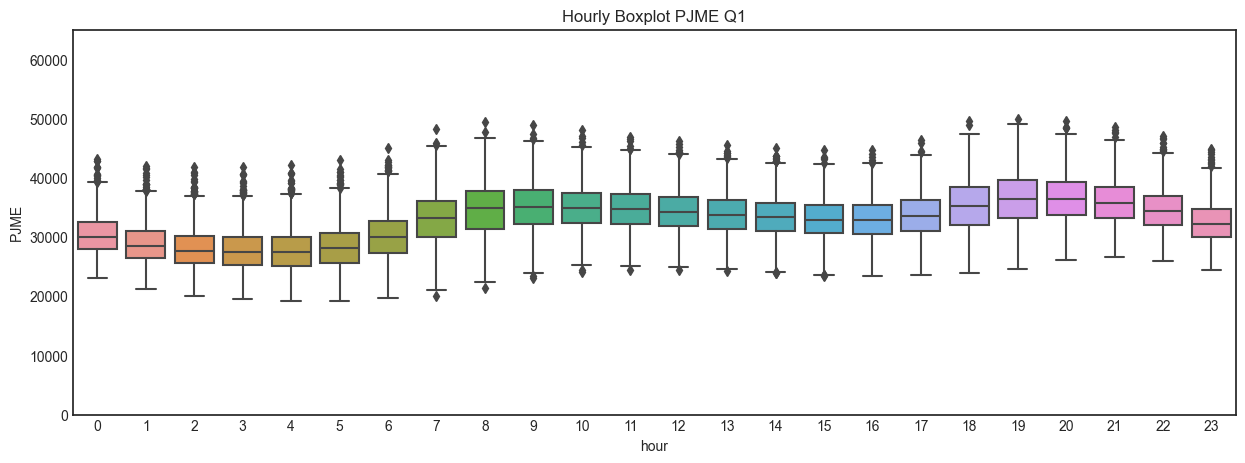

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='hour', y='PJME', data=df.loc[df['quarter']==1])
ax.set_title('Hourly Boxplot PJME Q1')
ax.set_ylim(0,65000)

(0.0, 65000.0)

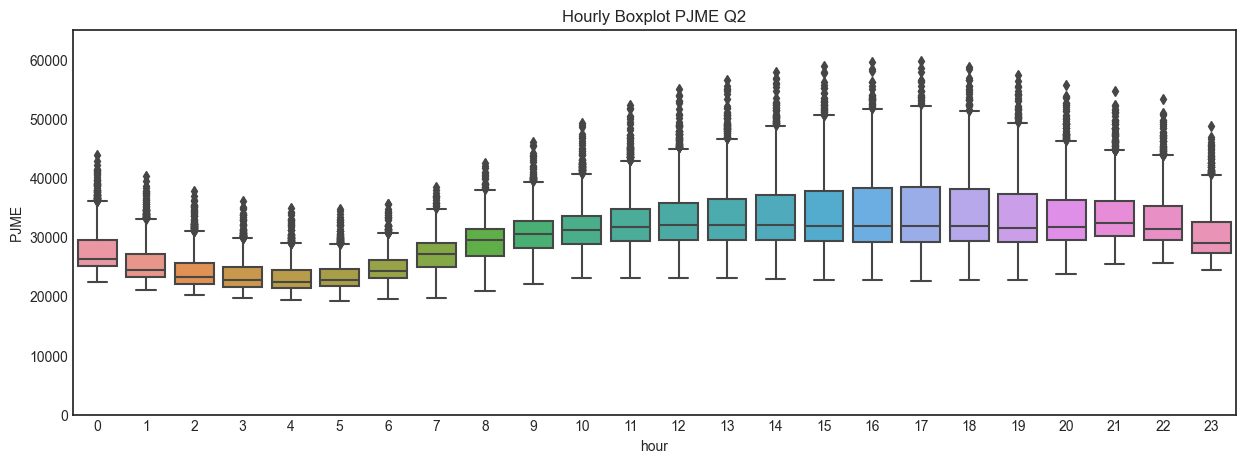

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='hour', y='PJME', data=df.loc[df['quarter']==2])
ax.set_title('Hourly Boxplot PJME Q2')
ax.set_ylim(0,65000)

(0.0, 65000.0)

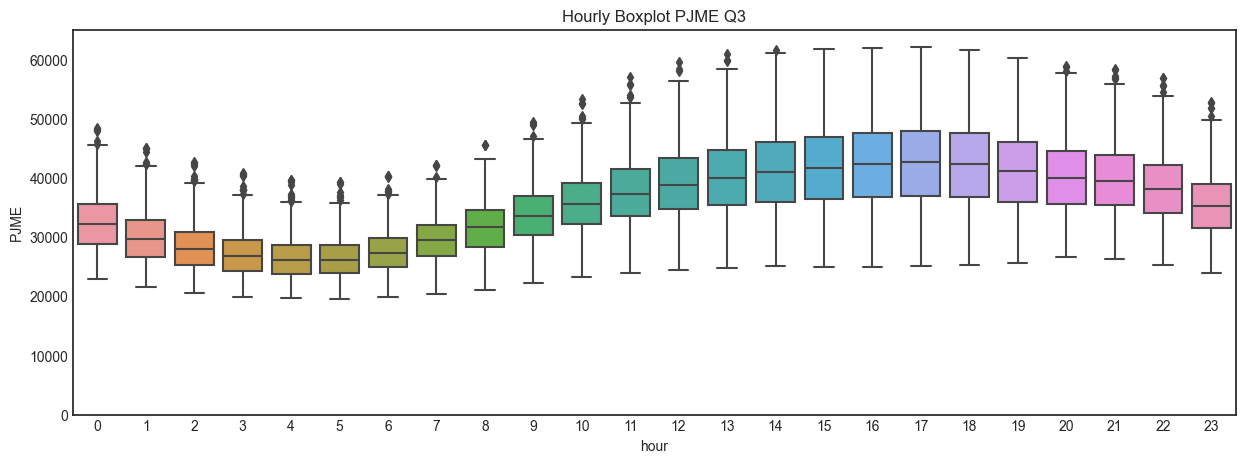

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='hour', y='PJME', data=df.loc[df['quarter']==3])
ax.set_title('Hourly Boxplot PJME Q3')
ax.set_ylim(0,65000)

(0.0, 65000.0)

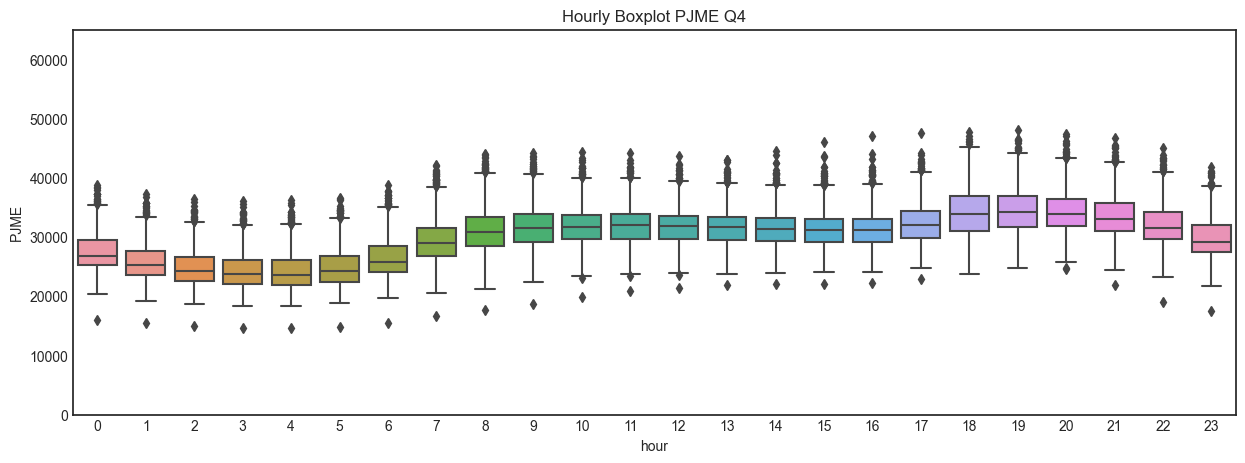

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='hour', y='PJME', data=df.loc[df['quarter']==4])
ax.set_title('Hourly Boxplot PJME Q4')
ax.set_ylim(0,65000)

# Let's focus on PJMW 

LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be efficient, scalable, and accurate, making it suitable for large-scale data sets and machine learning problems. LightGBM is developed by Microsoft and is open-source software.

Some key features of LightGBM include:

* Gradient-based One-Side Sampling (GOSS): a technique that reduces the number of samples used in the training process by selecting only those samples that have larger gradients.
* Exclusive Feature Bundling (EFB): a technique that bundles exclusive features together to reduce memory usage and improve training speed.
* Leaf-wise Tree Growth: LightGBM grows trees leaf-wise rather than level-wise, which can lead to better accuracy and faster training times.
* Support for Large-Scale Data: LightGBM can handle large datasets with millions or billions of instances and features.
* Cross-Platform Compatibility: LightGBM can run on Windows, Linux, and macOS, and supports multiple programming languages, including Python, R, and C++.

Overall, LightGBM is a powerful and flexible tool for building accurate and efficient machine learning models. It has become popular in both industry and academia due to its excellent performance and ease of use.

In [16]:
df = pd.read_csv('/Users/macbookpro/Desktop/LinkedIn Work/LinkedIn Posts/Predective Modeling Projects/Hourly Energy Consumption/PJMW_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

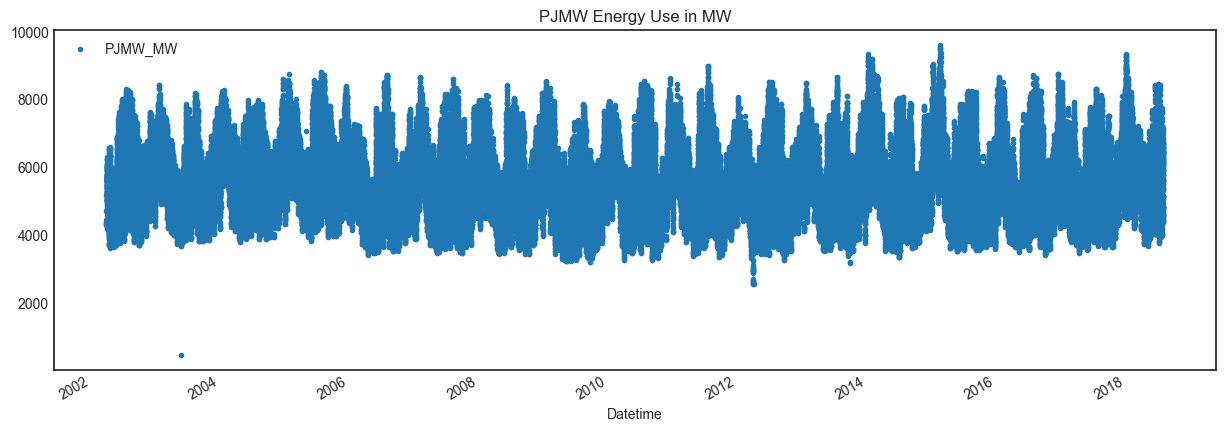

In [17]:
df.plot(style='.', 
        figsize=(15, 5), 
        color=color_pal[0], 
        title='PJMW Energy Use in MW')
plt.show()

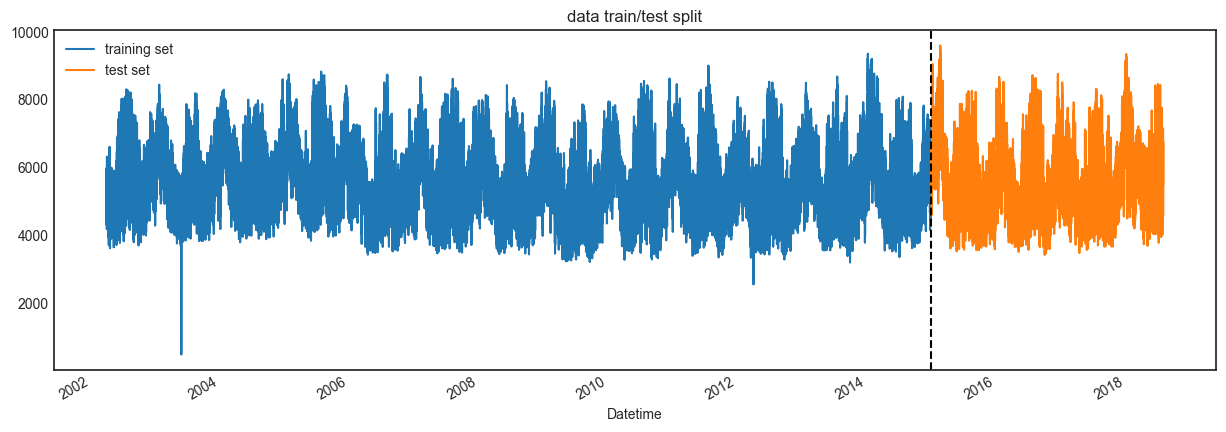

In [18]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='training set', title='data train/test split')
test.plot(ax=ax, label='test set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['training set', 'test set'])
plt.show()

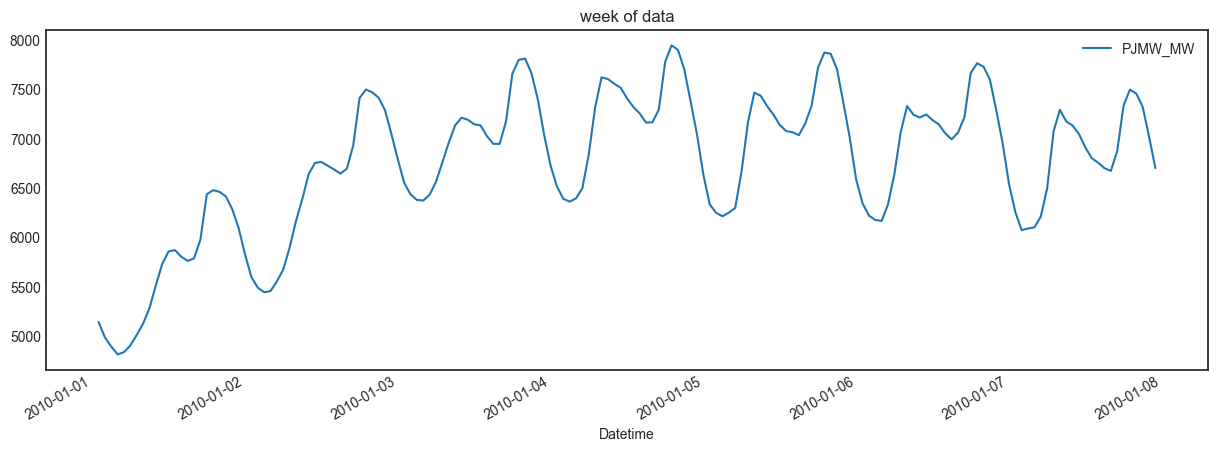

In [19]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
   .plot(figsize=(15, 5), title='week of data')
plt.show()

In [20]:
def create_features(df):
    #create time serires features based on time series index.
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear 
    return df

df = create_features(df)

<function matplotlib.pyplot.show(close=None, block=None)>

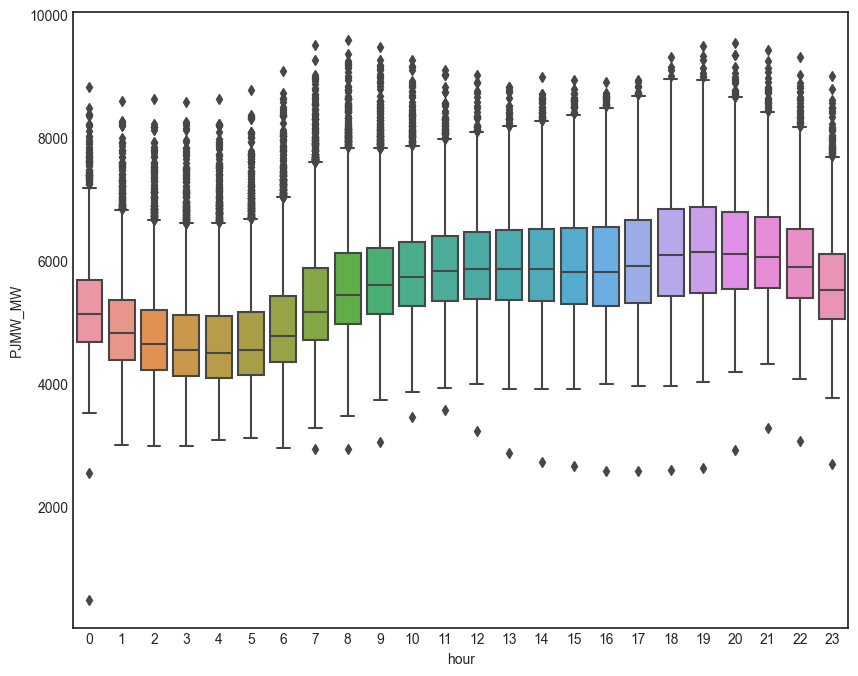

In [21]:
fig. ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJMW_MW')
ax.set_title('MW by Hour')
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

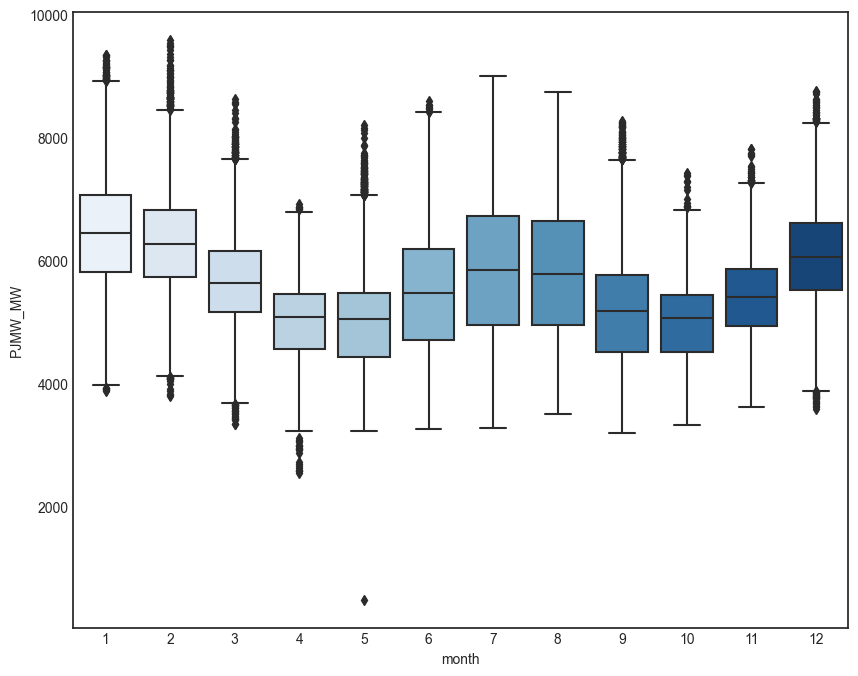

In [22]:
fig. ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJMW_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show 

In [23]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJMW_MW'

In [24]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [25]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for GridSearchCV
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.7, 0.8, 0.9]
}

# Create an instance of GridSearchCV
lgb_model = lgb.LGBMRegressor(objective='regression', metric='mae')
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=3)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print best hyperparameters and best mean cross-validated score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Train LightGBM model with best hyperparameters on entire training data
best_params = grid_search.best_params_
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
gbm = lgb.train(best_params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=50, verbose_eval=100)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV 1/3] END feature_fraction=0.7, learning_rate=0.01, num_leaves=15;, score=-536.342 total time=   0.4s
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV 2/3] END feature_fraction=0.7, learning_rate=0.01, num_leaves=15;, score=-566.196 total time=   0.4s
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV 3/3] END feature_fraction=0.7, learning_rate=0.01, num_leaves=15;, score=-555.183 total time=   0.4s
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[CV 1/3] END feature_fraction=0.7, learning_rate=0.01, num_leaves=31;, score=-526.169 total time=   0.5s
[LightGBM] [Warning] fe

[CV 1/3] END feature_fraction=0.8, learning_rate=0.05, num_leaves=15;, score=-470.499 total time=   0.4s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[CV 2/3] END feature_fraction=0.8, learning_rate=0.05, num_leaves=15;, score=-419.094 total time=   0.3s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[CV 3/3] END feature_fraction=0.8, learning_rate=0.05, num_leaves=15;, score=-425.216 total time=   0.3s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[CV 1/3] END feature_fraction=0.8, learning_rate=0.05, num_leaves=31;, score=-464.916 total time=   0.4s
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[CV 2/3] END feature_fraction=0.8, learning_rate=0.05, num_leaves=31;, score=-407.87

[CV 1/3] END feature_fraction=0.9, learning_rate=0.1, num_leaves=15;, score=-468.225 total time=   0.3s
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[CV 2/3] END feature_fraction=0.9, learning_rate=0.1, num_leaves=15;, score=-405.669 total time=   0.3s
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[CV 3/3] END feature_fraction=0.9, learning_rate=0.1, num_leaves=15;, score=-427.641 total time=   0.3s
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[CV 1/3] END feature_fraction=0.9, learning_rate=0.1, num_leaves=31;, score=-461.037 total time=   0.4s
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[CV 2/3] END feature_fraction=0.9, learning_rate=0.1, num_leaves=31;, score=-402.238 tot

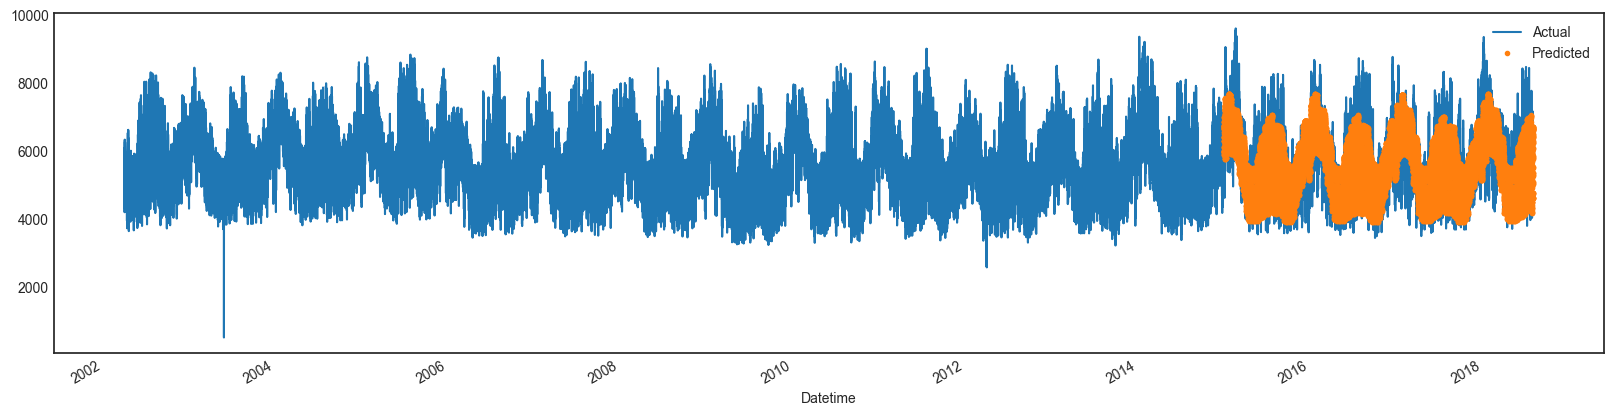

In [26]:
test['prediction'] = gbm.predict(X_test, num_iteration=gbm.best_iteration)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df['PJMW_MW'].plot(figsize=(20, 5))
df['prediction'].plot(style='.')
plt.legend(['Actual', 'Predicted'])
plt.show()

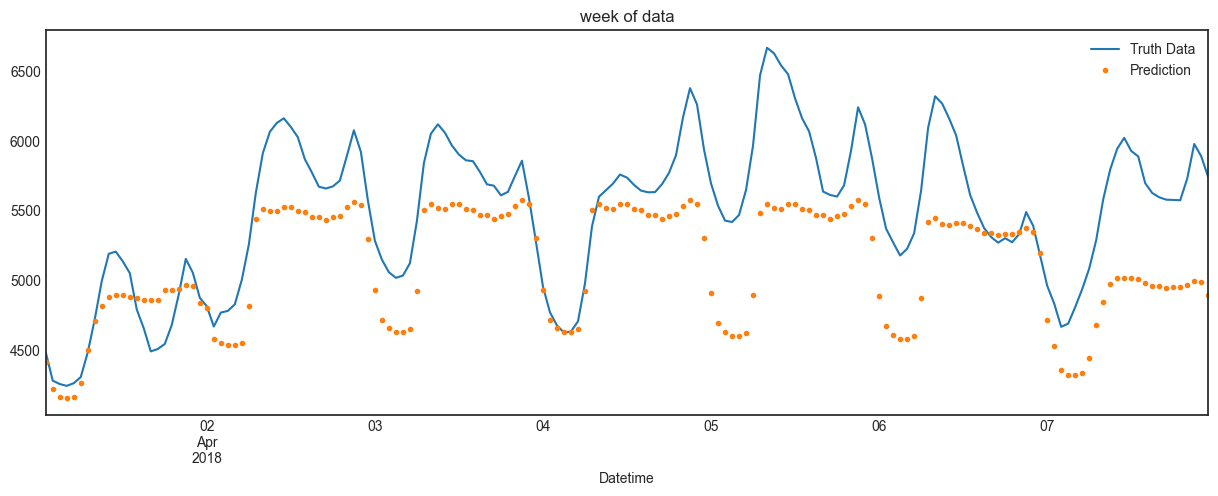

In [27]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')] ['PJMW_MW'] \
   .plot(figsize=(15, 5), title='week of data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')] ['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [28]:
score = np.sqrt(mean_squared_error(test['PJMW_MW'], test['prediction']))
print(f'RMSE Score on Test set:{score:0.2f}')

RMSE Score on Test set:644.88
